# Import Libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from tqdm.auto import tqdm 


import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

import re 
from collections import Counter
from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import precision_score, recall_score , f1_score, accuracy_score,confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from gensim.models import Word2Vec
import torch 
import torch.nn as nn  
from torch.optim import Adam
from torch.utils.data import DataLoader , TensorDataset
#from torchmetrics import ConfusionMatrix 
#from mlxtend.plotting import plot_confusion_matrix

lemma = WordNetLemmatizer()
lb = LabelEncoder()

In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...


True

# Loading Dataset

In [5]:
df = pd.read_csv('twitter_training.csv')

In [6]:
df.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [7]:
np.unique(df['Borderlands'])

array(['Amazon', 'ApexLegends', 'AssassinsCreed', 'Battlefield',
       'Borderlands', 'CS-GO', 'CallOfDuty', 'CallOfDutyBlackopsColdWar',
       'Cyberpunk2077', 'Dota2', 'FIFA', 'Facebook', 'Fortnite', 'Google',
       'GrandTheftAuto(GTA)', 'Hearthstone', 'HomeDepot',
       'LeagueOfLegends', 'MaddenNFL', 'Microsoft', 'NBA2K', 'Nvidia',
       'Overwatch', 'PlayStation5(PS5)',
       'PlayerUnknownsBattlegrounds(PUBG)', 'RedDeadRedemption(RDR)',
       'TomClancysGhostRecon', 'TomClancysRainbowSix', 'Verizon',
       'WorldOfCraft', 'Xbox(Xseries)', 'johnson&johnson'], dtype=object)

In [8]:
np.unique(df['Positive'])

array(['Irrelevant', 'Negative', 'Neutral', 'Positive'], dtype=object)

In [9]:
df = df.drop('2401' , axis=1)

In [10]:
df= df.rename(columns={"Borderlands":"Feature2","im getting on borderlands and i will murder you all ,":"Feature1","Positive": "labels"})

In [11]:
df.head()

,Feature2,labels,Feature1
0,Borderlands,Positive,I am coming to the borders and I will kill you...
1,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,Borderlands,Positive,im coming on borderlands and i will murder you...
3,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,Borderlands,Positive,im getting into borderlands and i can murder y...


In [12]:
df["tweets"]= df["Feature1"].astype(str) +" "+ df["Feature2"].astype(str)
df= df.drop(["Feature1","Feature2"],axis=1)

In [13]:
df_labels = {key : value for value , key in enumerate(np.unique(df['labels']))}
df_labels

{'Irrelevant': 0, 'Negative': 1, 'Neutral': 2, 'Positive': 3}

In [14]:
def getlabel(n) : 
    for x , y in df_labels.items() : 
        if y==n : 
            return x

# EDA

Text(0.5, 1.0, 'Percentage Label')

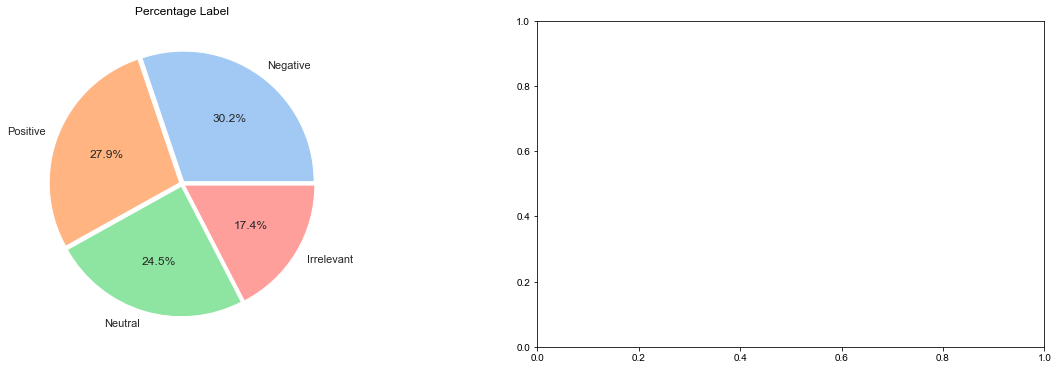

In [15]:
label_count = df['labels'].value_counts()
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

sns.set_theme(style='darkgrid', palette='pastel')
color = sns.color_palette(palette='pastel')
explode = [0.02]*len(label_count)

axes[0].pie(label_count.values, labels=label_count.index, autopct='%1.1f%%', colors=color, explode=explode)
axes[0].set_title('Percentage Label')

# sns.countplot(df['labels'] , ax=axes[1])
# axes[1].set_title('Count Label')
# axes[1].set_xlabel('Label')
# axes[1].set_ylabel('Count')

# plt.tight_layout()
# plt.show()

In [16]:
def Most_Words_used(tweets , num_of_words) : 
    all_text = ''.join(df[tweets].values) 
    
    all_text = re.sub('<.*?>', '', all_text) # HTML tags
    all_text = re.sub(r'\d+', '', all_text) # numbers
    all_text = re.sub(r'[^\w\s]', '', all_text) # special characters
    all_text = re.sub(r'http\S+', '', all_text) # URLs or web links
    all_text = re.sub(r'@\S+', '', all_text) # mentions
    all_text = re.sub(r'#\S+', '', all_text) # hashtags
    
    words = all_text.split() 
    
    # remove puncs 
    punc = list(punctuation) 
    words = [word for word in words if word not in punc]
    
    # remove stopwords 
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words]
    
    word_counts = Counter(words)
    
    top_words = word_counts.most_common(num_of_words)
    
    return top_words

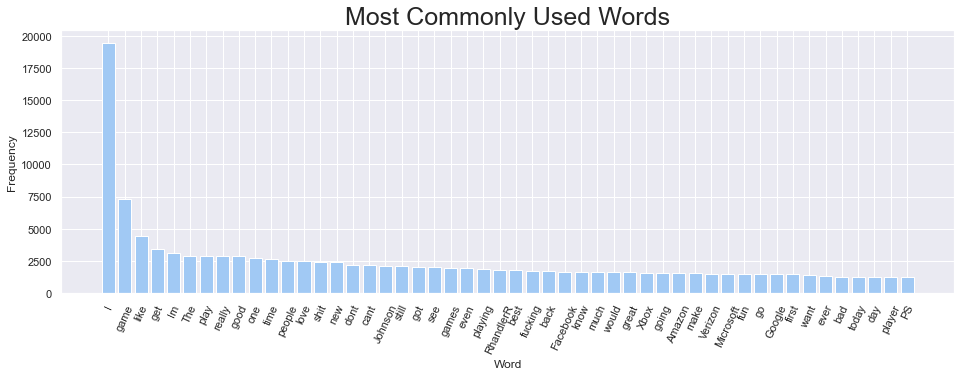

In [17]:
top_words = Most_Words_used('tweets' , 50)

xaxis = [word[0] for word in top_words]
yaxis = [word[1] for word in top_words]

plt.figure(figsize=(16,5))
plt.bar(xaxis , yaxis)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Commonly Used Words', fontsize=25)
plt.xticks(rotation=65)
plt.subplots_adjust(bottom=0.15)
plt.show()

# Data Preprocessing

In [22]:
def DataPrep(text) : 
    text = re.sub('<.*?>', '', text) # HTML tags
    text = re.sub(r'\d+', '', text) # numbers
    text = re.sub(r'[^\w\s]', '', text) # special characters
    text = re.sub(r'http\S+', '', text) # URLs or web links
    text = re.sub(r'@\S+', '', text) # mentions
    text = re.sub(r'#\S+', '', text) # hashtags
    
    # tokenization 
    tokens = nltk.word_tokenize(text) 
    
    # remove puncs 
    punc = list(punctuation)
    words = [word for word in tokens if word not in punc]
    
    # remove stopwords 
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word.lower() in stop_words]
    
    #Lemmatization 
    #words = [lemma.lemmatize(word) for word in words] 
    
    text = ' '.join(words)
    
    return text

In [23]:

df['cleaned_tweets'] = df['tweets'].apply(DataPrep)

In [24]:
print(f'There are around {int(df["cleaned_tweets"].duplicated().sum())} duplicated tweets, we will remove them.')

There are around 11806 duplicated tweets, we will remove them.


In [25]:
df.drop_duplicates("cleaned_tweets", inplace=True)

In [26]:
df['tweet_len'] = [len(text.split()) for text in df.cleaned_tweets]

In [27]:
df = df[df['tweet_len'] < df['tweet_len'].quantile(0.995)]

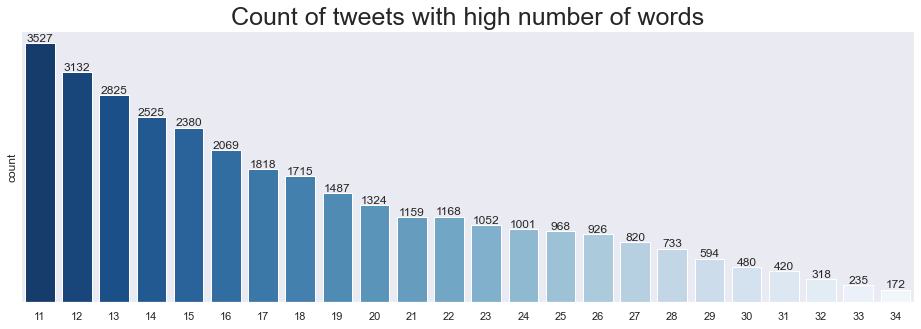

In [28]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='tweet_len', data=df[(df['tweet_len']<=1000) & (df['tweet_len']>10)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

# Split the data

In [29]:
x_train , x_val , y_train , y_val = train_test_split(df['cleaned_tweets'] , df['labels'] , train_size = 0.85 , random_state=42)

In [30]:
len(x_train) , len(x_val)

(53089, 9369)

# Feature Extraction

In [31]:
vec = TfidfVectorizer()
vec.fit(x_train)
#print("No. of feature words: ",len(vec.get_feature_names()))

TfidfVectorizer()

In [32]:
x_train = vec.transform(x_train).toarray()
x_val = vec.transform(x_val).toarray()

# Encoding

In [33]:
y_train = lb.fit_transform(y_train)
y_val = lb.fit_transform(y_val)

# Logistic Regression

In [34]:
lr = LogisticRegression(random_state=42)
lr.fit(x_train , y_train)

LogisticRegression(random_state=42)

In [35]:
train_acc1 = lr.score(x_train , y_train)

In [36]:
lr_pred = lr.predict(x_val)

val_acc1 = accuracy_score(y_val , lr_pred) 

val_precision1 = precision_score(y_val , lr_pred , average='weighted')
val_recall1 = recall_score(y_val , lr_pred , average='weighted')
val_f1score1 = f1_score(y_val , lr_pred , average='weighted')

In [37]:
print(f"The training accuracy for logistic regression : {(train_acc1*100):0.2f}%\n")
print(f"The validation accuracy for logistic regression : {(val_acc1*100):0.2f}%\n")
print(f"The precision for logistic regression : {val_precision1:0.2f}\n")
print(f"The recall for logistic regression : {val_recall1:0.2f}\n")
print(f"The f1 score for logistic regression : {val_f1score1:0.2f}\n")

The training accuracy for logistic regression : 61.87%

The validation accuracy for logistic regression : 59.90%

The precision for logistic regression : 0.60

The recall for logistic regression : 0.60

The f1 score for logistic regression : 0.59



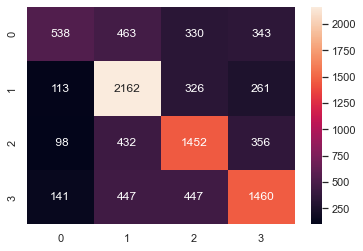

In [38]:
lr_cm = confusion_matrix(y_val , lr_pred)
sns.heatmap(lr_cm, annot=True,fmt='3g')
plt.show()

# Random Forest Classifier

In [39]:
rf = RandomForestClassifier()
rf.fit(x_train , y_train)

RandomForestClassifier()

In [40]:
train_acc2 = rf.score(x_train , y_train)

In [41]:
rf_pred = rf.predict(x_val)

val_acc2 = accuracy_score(y_val , lr_pred) 

val_precision2 = precision_score(y_val , rf_pred , average='weighted')
val_recall2 = recall_score(y_val , rf_pred , average='weighted')
val_f1score2 = f1_score(y_val , rf_pred , average='weighted')

In [42]:
print(f"The training accuracy for Random Forest : {(train_acc2*100):0.2f}%\n")
print(f"The validation accuracy for Random Forest : {(val_acc2*100):0.2f}%\n")
print(f"The precision for Random Forest : {val_precision2:0.2f}\n")
print(f"The recall for Random Forest : {val_recall2:0.2f}\n")
print(f"The f1 score for Random Forest : {val_f1score2:0.2f}\n")

The training accuracy for Random Forest : 65.97%

The validation accuracy for Random Forest : 59.90%

The precision for Random Forest : 0.63

The recall for Random Forest : 0.62

The f1 score for Random Forest : 0.61



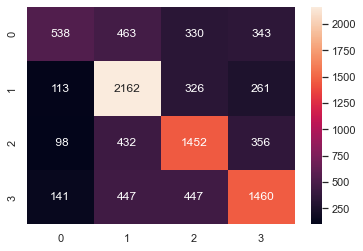

In [43]:
rf_cm = confusion_matrix(y_val , rf_pred)
sns.heatmap(lr_cm, annot=True,fmt='3g')
plt.show()

# LSTM

Data preprocessing for LSTM

In [44]:
MAX_LEN = np.max(df['tweet_len'])
MAX_LEN

34

In [45]:
def lstm_prep(column , seq_len) : 
    # create a vocab of words 
    corpus = [word for text in column for word in text.split()]
    words_count = Counter(corpus) 
    sorted_words = words_count.most_common()
    vocab_to_int = {w:i+1 for i , (w,c) in enumerate(sorted_words)}
    
    text_int = [] 
    
    for text in column : 
        token = [vocab_to_int[word] for word in text.split()]
        text_int.append(token)
        
        
    # padding 
    features = np.zeros((len(text_int) , seq_len) , dtype = int)
    for idx , y in tqdm(enumerate(text_int)) : 
        if len(y) <= seq_len : 
            zeros = list(np.zeros(seq_len - len(y)))
            new = zeros + y
            
        else : 
            new = y[:seq_len]
            
        features[idx,:] = np.array(new)
        
    return sorted_words, features

In [46]:
VOCAB , tokenized_column = lstm_prep(df['cleaned_tweets'] , MAX_LEN)

0it [00:00, ?it/s]

In [47]:
VOCAB[:10]

[('game', 6778),
 ('like', 4151),
 ('Im', 3716),
 ('Facebook', 3638),
 ('Microsoft', 3637),
 ('Amazon', 3458),
 ('Verizon', 3417),
 ('get', 3276),
 ('Google', 3267),
 ('Battlefield', 3135)]

In [48]:
len(VOCAB)

45521

In [49]:
tokenized_column.shape

(62458, 34)

In [51]:
def most_common_words(vocab) : 
    keys = [] 
    values = [] 
    for key , value in vocab[:30] : 
        keys.append(key) 
        values.append(value)
        
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(keys, values, palette='mako')
    plt.title('Top 20 most common words', size=25)
    ax.bar_label(ax.containers[0])
    plt.ylabel("Words count")
    plt.xticks(rotation=45)
    plt.subplots_adjust(bottom=0.15)
    plt.show()
    
#most_common_words(VOCAB)

In [52]:
X = tokenized_column
y = lb.fit_transform(df['labels'].values)

In [53]:
X_train , X_val , Y_train , Y_val = train_test_split(X , y , train_size=0.85 , random_state=42)

In [54]:
train_data = TensorDataset(torch.from_numpy(X_train), torch.LongTensor(Y_train))
val_data = TensorDataset(torch.from_numpy(X_val), torch.LongTensor(Y_val))

Create DataLoaders

In [55]:
BATCH_SIZE = 64

In [56]:
torch.manual_seed(42)
train_dataloader = DataLoader(
    dataset = train_data , 
    batch_size=BATCH_SIZE , 
    shuffle=True
)

In [57]:
torch.manual_seed(42) 
val_dataloader = DataLoader(
    dataset = val_data , 
    batch_size = BATCH_SIZE , 
    shuffle=False
)

In [58]:
print(f"the size of the train dataloader {len(train_dataloader)} batches of {BATCH_SIZE}")

the size of the train dataloader 830 batches of 64


In [59]:
print(f"the size of the validation dataloader {len(val_dataloader)} batches of {BATCH_SIZE}")

the size of the validation dataloader 147 batches of 64


Word Embedding by Word2Vec

In [60]:
EMBEDDING_DIM = 200

In [61]:
Word2vec_train_data = list(map(lambda x: x.split(), df['cleaned_tweets']))

In [62]:
word2vec_model = Word2Vec(Word2vec_train_data, vector_size=EMBEDDING_DIM)

In [63]:
def weight_matrix(model,vocab):
    vocab_size= len(vocab)+1
    embedding_matrix = np.zeros((vocab_size,EMBEDDING_DIM))
    for word, token in vocab:
        if model.wv.__contains__(word):
            embedding_matrix[token]=model.wv.__getitem__(word)
    return embedding_matrix

In [64]:
embedding_vec = weight_matrix(word2vec_model,VOCAB)
print("Embedding Matrix Shape:", embedding_vec.shape)

Embedding Matrix Shape: (45522, 200)


Build our model

In [65]:
def param_count(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    print('The Total number of parameters in the model : ', sum(params))

In [66]:
class LSTM(nn.Module) : 
    def __init__(self , vocab_size , embedding_dim 
                 , num_layers , hidden_dim , out_channels , bidirectional) : 
        super().__init__() 
         
        self.no_layers = num_layers 
        self.hidden_dim = hidden_dim 
        self.out_channels = out_channels
        self.num_directions = 2 if bidirectional else 1  
        self.embedding = nn.Embedding(vocab_size , embedding_dim)
        
        self.lstm = nn.LSTM(
            embedding_dim , 
            hidden_dim , 
            num_layers , 
            dropout = 0.5 , 
            bidirectional = bidirectional , 
            batch_first = True
        )
        
        self.fc = nn.Linear(hidden_dim*self.num_directions , out_channels)
        
        
    def forward(self , x) : 
        h0 = torch.zeros((self.no_layers * self.num_directions , x.size(0) , self.hidden_dim))
        c0 = torch.zeros((self.no_layers * self.num_directions , x.size(0) , self.hidden_dim))
        
        embedded = self.embedding(x)
        
        out , _ = self.lstm(embedded , (h0 , c0))
        
        out = out[:,-1,:]
        
        out = self.fc(out)
        
        return out 

In [67]:
# define parameters 
VOCAB_SIZE = len(VOCAB) + 1
NUM_LAYERS = 2 
OUT_CHANNELS = 4 
HIDDEN_DIM = 256
BIDIRECTIONAL = True

model = LSTM(VOCAB_SIZE , EMBEDDING_DIM , NUM_LAYERS , HIDDEN_DIM , OUT_CHANNELS , BIDIRECTIONAL)

model.embedding.weight.data.copy_(torch.from_numpy(embedding_vec))

model.embedding.weight.requires_grad = True

In [68]:
param_count(model)

The Total number of parameters in the model :  11621396


In [69]:
criterion=nn.CrossEntropyLoss()
optimizer=Adam(model.parameters(),lr=0.001)

Train our model

In [75]:
epochs = 10 
training_loss = []
training_acc = [] 
for i in tqdm(range(epochs)) : 
    epoch_loss = 0
    epoch_acc = 0 
 
    for batch , (x_train , y_train) in enumerate(train_dataloader) : 
    
        y_pred = model(x_train)
        
        loss = criterion(y_pred , y_train) 
        
        if batch % 500 == 0:
            print("inside and l=",len(x_train))
            print(f"Looked at {batch * len(x_train)}/{len(train_dataloader.dataset)} samples.")
          

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        epoch_loss +=loss 
        epoch_acc += accuracy_score(y_train , y_pred.argmax(dim=1))
        
        
    training_loss.append((epoch_loss/len(train_dataloader)).detach().numpy())
    training_acc.append(epoch_acc/len(train_dataloader))
    
    print(f"Epoch {i+1}: Accuracy: {(epoch_acc/len(train_dataloader)) * 100}, Loss: {(epoch_loss/len(train_dataloader))}\n\n")

  0%|          | 0/10 [00:00<?, ?it/s]

inside and l= 64
Looked at 0/53089 samples.
inside and l= 64
Looked at 3200/53089 samples.
inside and l= 64
Looked at 6400/53089 samples.
inside and l= 64
Looked at 9600/53089 samples.
Epoch 1: Accuracy: 14.742093373493976, Loss: 0.09279754012823105


inside and l= 64
Looked at 0/53089 samples.
inside and l= 64
Looked at 3200/53089 samples.


KeyboardInterrupt: 

In [ ]:
print(f"The loss of the training set is : {training_loss[-1]:0.2f}")
print(f"The accuracy of the training set is : {(training_acc[-1]*100):0.2f}%")

The loss of the training set is : 0.03
The accuracy of the training set is : 98.91%


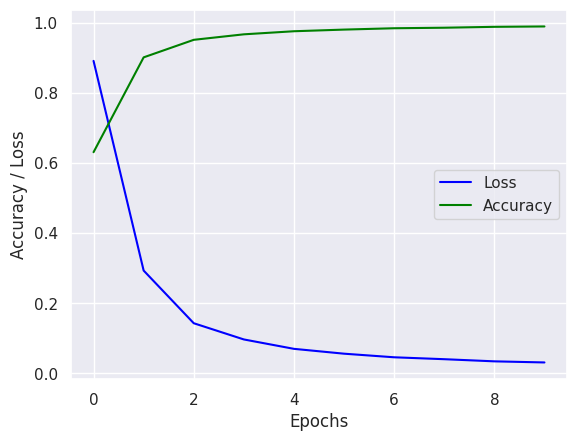

In [ ]:
plt.plot(range(epochs),training_loss,color="blue",label="Loss")
plt.plot(range(epochs),training_acc,color="green",label="Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.show()

Test our model

In [3]:
val_loss=0
val_acc3= 0
lstm_preds=[]
val_targets = []
torch.manual_seed(42)
with torch.no_grad() : 
        for x_val , y_val in tqdm(val_dataloader) : 
            y_pred=model.forward(x_val)
            val_pred = torch.softmax(y_pred , dim=1 ).argmax(dim=1)
            lstm_preds.append(val_pred)
            val_targets.extend(y_val)
            
            loss=criterion(y_pred,y_val)
            val_loss+=loss
            val_acc3 += accuracy_score(y_val , y_pred.argmax(dim=1))
            
            
val_loss/=len(val_dataloader)
val_acc3/=len(val_dataloader)
lstm_preds = torch.cat(lstm_preds)
val_targets = torch.Tensor(val_targets)

NameError: name 'torch' is not defined

In [2]:
train_acc3 = training_acc[-1]
val_precision3 = precision_score(val_targets,lstm_preds,average='weighted')
val_recall3 = recall_score(val_targets,lstm_preds,average='weighted')
val_f1score3 = f1_score(val_targets,lstm_preds,average='weighted')

NameError: name 'training_acc' is not defined

Measuring performance

In [ ]:
print(f"The training accuracy for LSTM : {(train_acc3*100):0.2f}%\n")
print(f"The validation accuracy for LSTM : {(val_acc3*100):0.2f}%\n")
print(f"The precision for LSTM : {val_precision3:0.2f}\n")
print(f"The recall for LSTM : {val_recall3:0.2f}\n")
print(f"The f1 score for LSTM : {val_f1score3:0.2f}\n")
print(f"The training loss for LSTM : {training_loss[-1]:0.2f}\n")
print(f"The validation loss for LSTM : {val_loss:0.2f}\n")

In [ ]:
confmat = ConfusionMatrix(num_classes=4, task='multiclass')
confmat_tensor = confmat(preds=lstm_preds,
                         target=val_targets)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=df_labels.keys(),
    figsize=(10, 7)
)

# Compare between models

In [ ]:
train_scores=[train_acc1,train_acc2,train_acc3]
val_scores=[val_acc1,val_acc2,val_acc3]

models = ['Logistic Regression','RandomForest','LSTM']

x = np.arange(len(models))

width = 0.25

fig, ax = plt.subplots(figsize=(20, 10))

rects1 = ax.bar(x - width, train_scores, width, label='Train Accuracy')

rects2 = ax.bar(x + width, val_scores, width, label='Validation Accuracy')

ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Training and Validation Accuracies')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 2),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()